In [2]:
#The user may change this section if they prefer other IDE like VS code,...
#Here I am using the google colab and I am connecting to the google Drive where the simulation.py and Glassform.so are located
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab_Notebooks/Git_versions')
import sys
import os

# Set the working directory
os.chdir('/content/drive/My Drive/Colab_Notebooks/Git_versions')

# test
#if anything is wrong(missing files, not connecting to Drive,..) we shall see the error after running this import
from simulator import GlassformSimulator

Mounted at /content/drive


Steady state reached at cycle 108

Steady State Information:
Steady Point Cycle: 108
Steady Mold Temperature: 374.73°C
Steady Gob Temperature: 968.80°C
Steady t_contact: 106.00°
Steady t_cooling: 120.00°


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Final Results (After Steady State):
Nominal - Final Gob Temperature: 968.79°C
Nominal - Final Mold Temperature: 374.72°C
Nominal - t_contact (°): 106.00
Nominal - t_cooling (°): 120.00
+10% Contact - Final Gob Temperature: 967.22°C
+10% Contact - Final Mold Temperature: 378.70°C
+10% Contact - t_contact (°): 116.60
+10% Contact - t_cooling (°): 120.00
-10% Contact - Final Gob Temperature: 970.01°C
-10% Contact - Final Mold Temperature: 371.54°C
-10% Contact - t_contact (°): 95.40
-10% Contact - t_cooling (°): 120.00


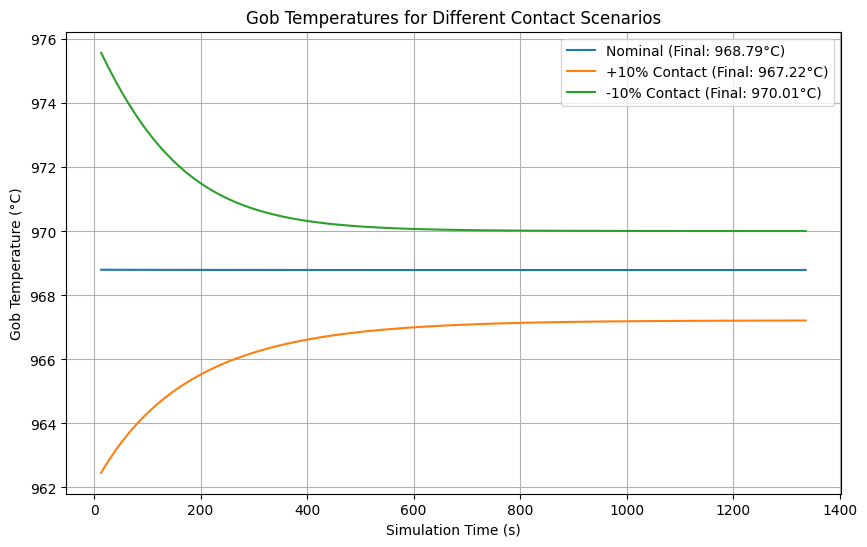

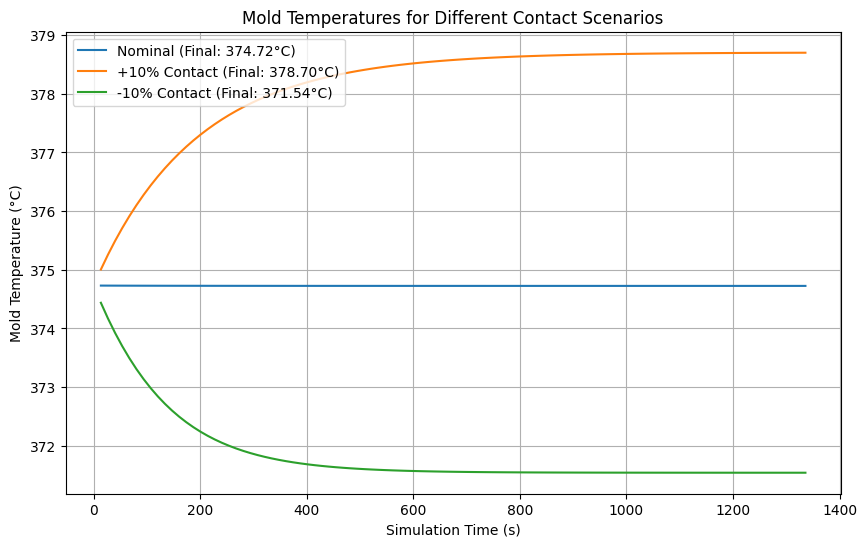

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from simulator import GlassformSimulator  # Ensure simulator.py is in the current directory
from google.colab import files  # Only needed in Google Colab for downloading files

# Constants
CYCLE_LENGTH_S = 13.36  # Total cycle length in seconds
CONTACT_NOMINAL_DEG = 106  # Nominal contact time in degrees
COOLING_NOMINAL_DEG = 120  # Nominal cooling time in degrees
PROPORTION_SETTLE = 0.6  # Proportion of settle in contact
PROPORTION_COUNTER = 0.4  # Proportion of counter in contact
STEADY_WINDOW = 50  # Number of cycles for steady-state detection
SLOPE_THRESHOLD = 0.01  # Threshold for steady-state slope
CONTACT_VARIATION = 0.10  # 10% variation for increased and decreased contact

# Conversion functions
def degrees_to_seconds(degrees):
    """Convert machine degrees to seconds."""
    return (degrees / 360) * CYCLE_LENGTH_S

def seconds_to_degrees(time_s):
    """Convert seconds to machine degrees."""
    return (time_s / CYCLE_LENGTH_S) * 360

# Initialize the simulator
simulator = GlassformSimulator()

# File paths
file_path_steady = '/content/simulation_steady_log.csv'
file_path_experiments = '/content/simulation_experiments_log.csv'

# ====== Steady State Detection ======
with open(file_path_steady, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([
        'Cycle', 'Time (s)', 'T_gob (Parison Temperature)', 'T_mold (Mold Temperature)',
        't_contact (°)', 't_cooling (°)'
    ])

    gob_temps = []
    mold_temps = []
    time_steps = []
    steady_cycle = None

    simulator.reset(T_mold=400.5)
    simulator.T_gob = 1100
    simulator.T_air = 50
    simulator.t_settle = degrees_to_seconds(PROPORTION_SETTLE * CONTACT_NOMINAL_DEG)
    simulator.t_counter = degrees_to_seconds(PROPORTION_COUNTER * CONTACT_NOMINAL_DEG)
    simulator.t_cooling = degrees_to_seconds(COOLING_NOMINAL_DEG)

    for i in range(1000):  # Simulate for up to 1000 cycles
        simulator.simulate_cycle()
        gob_temp = simulator.T_parison
        mold_temp = simulator.T_mold
        time_step = simulator.time

        # Calculate t_contact and t_cooling in degrees
        t_contact_deg = seconds_to_degrees(simulator.t_settle) + seconds_to_degrees(simulator.t_counter)
        t_cooling_deg = seconds_to_degrees(simulator.t_cooling)

        # Log data
        writer.writerow([i, time_step, gob_temp, mold_temp, t_contact_deg, t_cooling_deg])

        # Store results
        gob_temps.append(gob_temp)
        mold_temps.append(mold_temp)
        time_steps.append(time_step)

        # Check steady state only after enough cycles for the window
        if i >= STEADY_WINDOW:
            recent_temps = gob_temps[-STEADY_WINDOW:]  # Last `STEADY_WINDOW` cycles
            slope = (recent_temps[-1] - recent_temps[0]) / STEADY_WINDOW

            if abs(slope) <= SLOPE_THRESHOLD:  # Check if slope is within the threshold
                steady_cycle = i
                print(f"Steady state reached at cycle {steady_cycle}")
                break

if steady_cycle is None:
    print("Steady state not reached within the simulation time.")
else:
    steady_mold_temp = mold_temps[steady_cycle]
    steady_gob_temp = gob_temps[steady_cycle]
    steady_t_contact = seconds_to_degrees(simulator.t_settle) + seconds_to_degrees(simulator.t_counter)
    steady_t_cooling = seconds_to_degrees(simulator.t_cooling)
    print("\nSteady State Information:")
    print(f"Steady Point Cycle: {steady_cycle}")
    print(f"Steady Mold Temperature: {steady_mold_temp:.2f}°C")
    print(f"Steady Gob Temperature: {steady_gob_temp:.2f}°C")
    print(f"Steady t_contact: {steady_t_contact:.2f}°")
    print(f"Steady t_cooling: {steady_t_cooling:.2f}°")

files.download(file_path_steady)

# ====== Experiments Starting from Steady State ======
with open(file_path_experiments, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([
        'Variation', 'Cycle', 'Time (s)', 'T_gob (Parison Temperature)', 'T_mold (Mold Temperature)',
        't_contact (°)', 't_cooling (°)'
    ])

    # Variations for contact
    variations = [
        {"label": "Nominal", "variation": 0},
        {"label": "+10% Contact", "variation": CONTACT_VARIATION},
        {"label": "-10% Contact", "variation": -CONTACT_VARIATION},
    ]

    results = {}
    for variation in variations:
        label = variation["label"]
        contact_deg = CONTACT_NOMINAL_DEG * (1 + variation["variation"])
        t_settle_s = degrees_to_seconds(PROPORTION_SETTLE * contact_deg)
        t_counter_s = degrees_to_seconds(PROPORTION_COUNTER * contact_deg)

        simulator.reset(T_mold=steady_mold_temp)
        simulator.T_gob = 1100
        simulator.T_air = 50
        simulator.t_settle = t_settle_s
        simulator.t_counter = t_counter_s
        simulator.t_cooling = degrees_to_seconds(COOLING_NOMINAL_DEG)

        gob_temps = []
        mold_temps = []
        time_steps = []

        for i in range(100):  # Simulate 100 cycles
            simulator.simulate_cycle()
            gob_temp = simulator.T_parison
            mold_temp = simulator.T_mold
            time_step = simulator.time

            # Calculate t_contact and t_cooling in degrees
            t_contact_deg = seconds_to_degrees(simulator.t_settle) + seconds_to_degrees(simulator.t_counter)
            t_cooling_deg = seconds_to_degrees(simulator.t_cooling)

            # Log data
            writer.writerow([label, i+1, time_step, gob_temp, mold_temp, t_contact_deg, t_cooling_deg])

            # Append the results to lists for plotting
            gob_temps.append(gob_temp)
            mold_temps.append(mold_temp)
            time_steps.append(time_step)

        results[label] = {
            "time": time_steps,
            "gob_temp": gob_temps,
            "mold_temp": mold_temps,
            "final_gob_temp": gob_temps[-1],
            "final_mold_temp": mold_temps[-1],
            "t_contact_deg": t_contact_deg,
            "t_cooling_deg": t_cooling_deg,
        }
# Print results for all variations
print("\nFinal Results (After Steady State):")
for label, data in results.items():
    print(f"{label} - Final Gob Temperature: {data['final_gob_temp']:.2f}°C")
    print(f"{label} - Final Mold Temperature: {data['final_mold_temp']:.2f}°C")
    print(f"{label} - t_contact (°): {data['t_contact_deg']:.2f}")
    print(f"{label} - t_cooling (°): {data['t_cooling_deg']:.2f}")

# Plot Gob Temperatures
plt.figure(figsize=(10, 6))
for label, data in results.items():
    plt.plot(
        data["time"], data["gob_temp"],
        label=f"{label} (Final: {data['final_gob_temp']:.2f}°C)"
    )
plt.xlabel("Simulation Time (s)")
plt.ylabel("Gob Temperature (°C)")
plt.title("Gob Temperatures for Different Contact Scenarios")
plt.legend()
plt.grid(True)
plt.show()

# Plot Mold Temperatures
plt.figure(figsize=(10, 6))
for label, data in results.items():
    plt.plot(
        data["time"], data["mold_temp"],
        label=f"{label} (Final: {data['final_mold_temp']:.2f}°C)"
    )
plt.xlabel("Simulation Time (s)")
plt.ylabel("Mold Temperature (°C)")
plt.title("Mold Temperatures for Different Contact Scenarios")
plt.legend()
plt.grid(True)
plt.show()

files.download(file_path_experiments)